# Competition and Data
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn as sk
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from IPython.display import display, HTML
# Set maximum number of rows to display using HTML to 20
pd.set_option('display.max_rows', 20)


In [3]:
import os
import random

# Set seeds
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
set_seeds(42)

In [4]:
from pathlib import Path

kaggle_path = Path('/kaggle/input/house-prices-advanced-regression-techniques')
data_path = Path('./Data')
data_path = kaggle_path

train_data = pd.read_csv(data_path / 'train.csv', dtype={'MSSubClass': ('object', 'category')[0]})
test_data = pd.read_csv(data_path / 'test.csv', dtype={'MSSubClass': ('object', 'category')[0]})

# Data Overview

In [5]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
HTML(train_data.head().to_html())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# Select numerical columns and use the describe method to get some statistics
HTML(train_data.select_dtypes(include=['int64', 'float64']).describe().to_html())

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
HTML(train_data.select_dtypes(include=['object', 'category']).describe().to_html())

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,15,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,536,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [10]:
# Find the number of missing values in each column
null_values = train_data.isnull().sum()
# Only display columns with missing values
null_only = null_values[null_values > 0]
# Percentage of missing values
null_only_pct = null_only / train_data.shape[0] * 100

# Combine the two series into a dataframe
null_df = pd.concat([null_only, null_only_pct], axis=1)
null_df.columns = ['Missing values', '% missing values']
null_df

,Missing values,% missing values
LotFrontage,259,17.739726
Alley,1369,93.767123
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtFinType2,38,2.602740
Electrical,1,0.068493


# Exploratory Data Analysis
* Sale Price
* Dwelling Types
* Zoning
* Street Type
* Alley Type
* Property Shape
* Property Contour
* Property Age
* SalePrice vs Living Area
* SalePrice Trend (e.g. Boxplots)


Text(0.5, 1.0, 'SalePrice Box Plot')

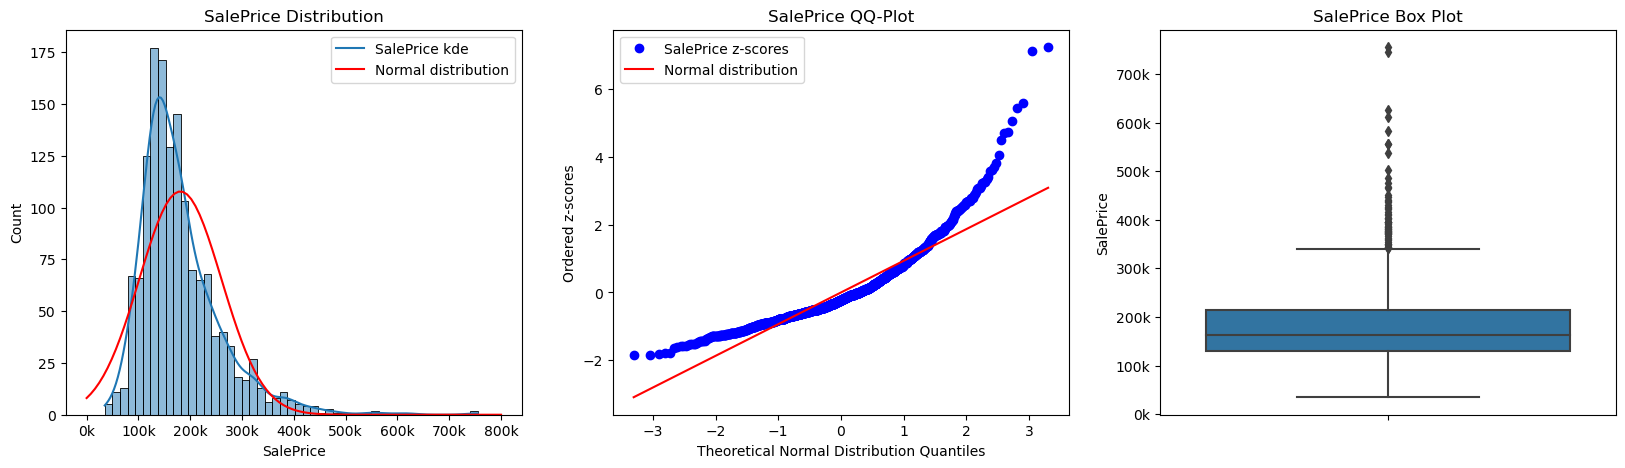

In [11]:
# Plot price distribution with seaborn with x axis in thoudands
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(train_data['SalePrice'], kde=True, ax=ax[0])
# Format x axis to be in thousands with the appropriate labels (e.g. 100 instead of 100,000)
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))
ax[0].set_title('SalePrice Distribution')

# Fit a normal distribution to the data
mu, sigma = stats.norm.fit(train_data['SalePrice'])
x = np.linspace(0, 800000, 100)
y = stats.norm.pdf(x, mu, sigma) # pdf area is always 1

# Bin width of bins in the histplot
bin_width = ax[0].patches[0].get_width()
# Number of values
n = len(train_data['SalePrice'])
# Area of the histogram
hist_area = n * bin_width
# Scale pdf to match the histogram
y = y * hist_area # pdf area is always 1

#plot it on the histogram with a red line
sns.lineplot(x=x, y=y, color='red', ax=ax[0])
# Add a legend
ax[0].legend(['SalePrice kde', 'Normal distribution'])

# Compute the z-scores for the SalePrice column
z_scores = stats.zscore(train_data['SalePrice'])

# QQ-Plot to compare the distribution z-scores of the data to a normal distribution
stats.probplot(z_scores, dist='norm', plot=ax[1])
#stats.probplot(z_scores, dist='lognorm', sparams=(0.5,), plot=ax[1])
ax[1].set_title('SalePrice QQ-Plot')
ax[1].set_ylabel('Ordered z-scores')
ax[1].set_xlabel('Theoretical Normal Distribution Quantiles')
ax[1].legend(['SalePrice z-scores', 'Normal distribution'])

# Boxplot of the SalePrice column
sns.boxplot(y=train_data['SalePrice'], ax=ax[2])
# Show 100 instead of 100,000
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))
# Add a title
ax[2].set_title('SalePrice Box Plot')

In [12]:
len(train_data.select_dtypes(include=['int64', 'float64']).columns)

37

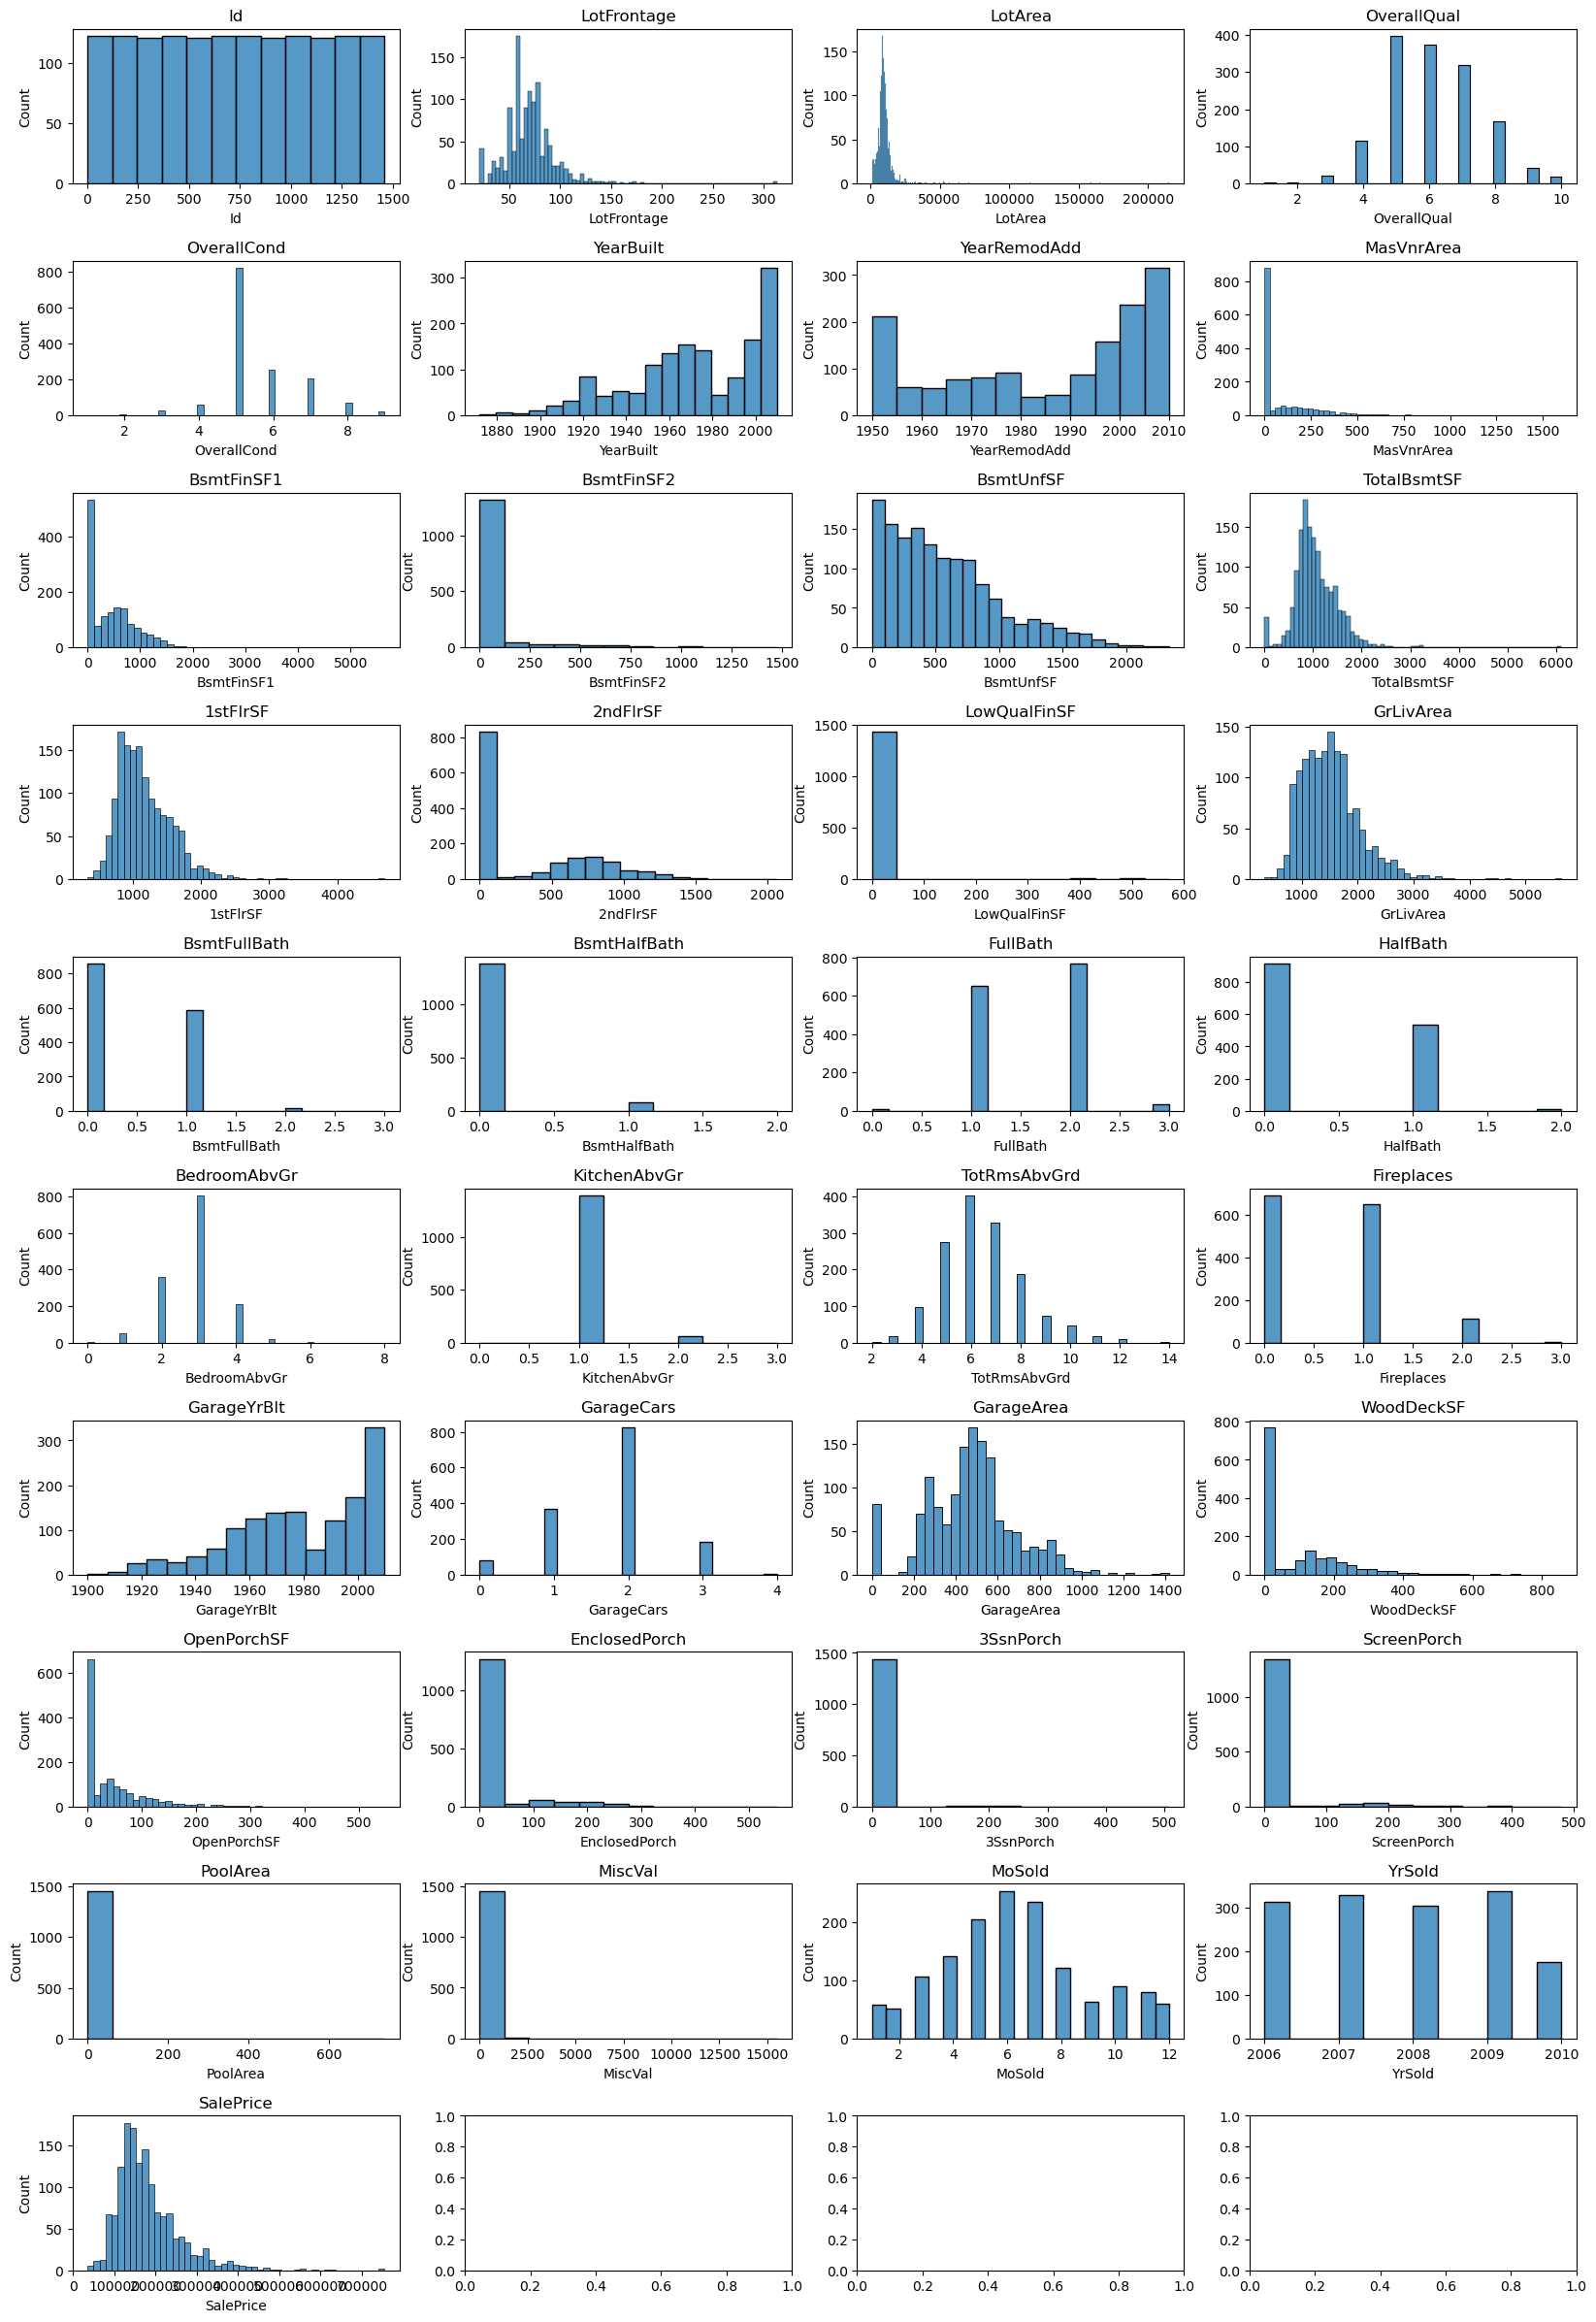

In [13]:
# Plot the distribution of each numerical column with increased vertical space between plots
fig, ax = plt.subplots(10, 4, figsize=(20, 30))
fig.subplots_adjust(hspace=0.5)
for i, col in enumerate(train_data.select_dtypes(include=['int64', 'float64']).columns):
    sns.histplot(train_data[col], kde=False, ax=ax[i//4, i%4])
    #sns.boxplot(y=train_data[col], ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(col)
    #ax[i//4, i%4].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))


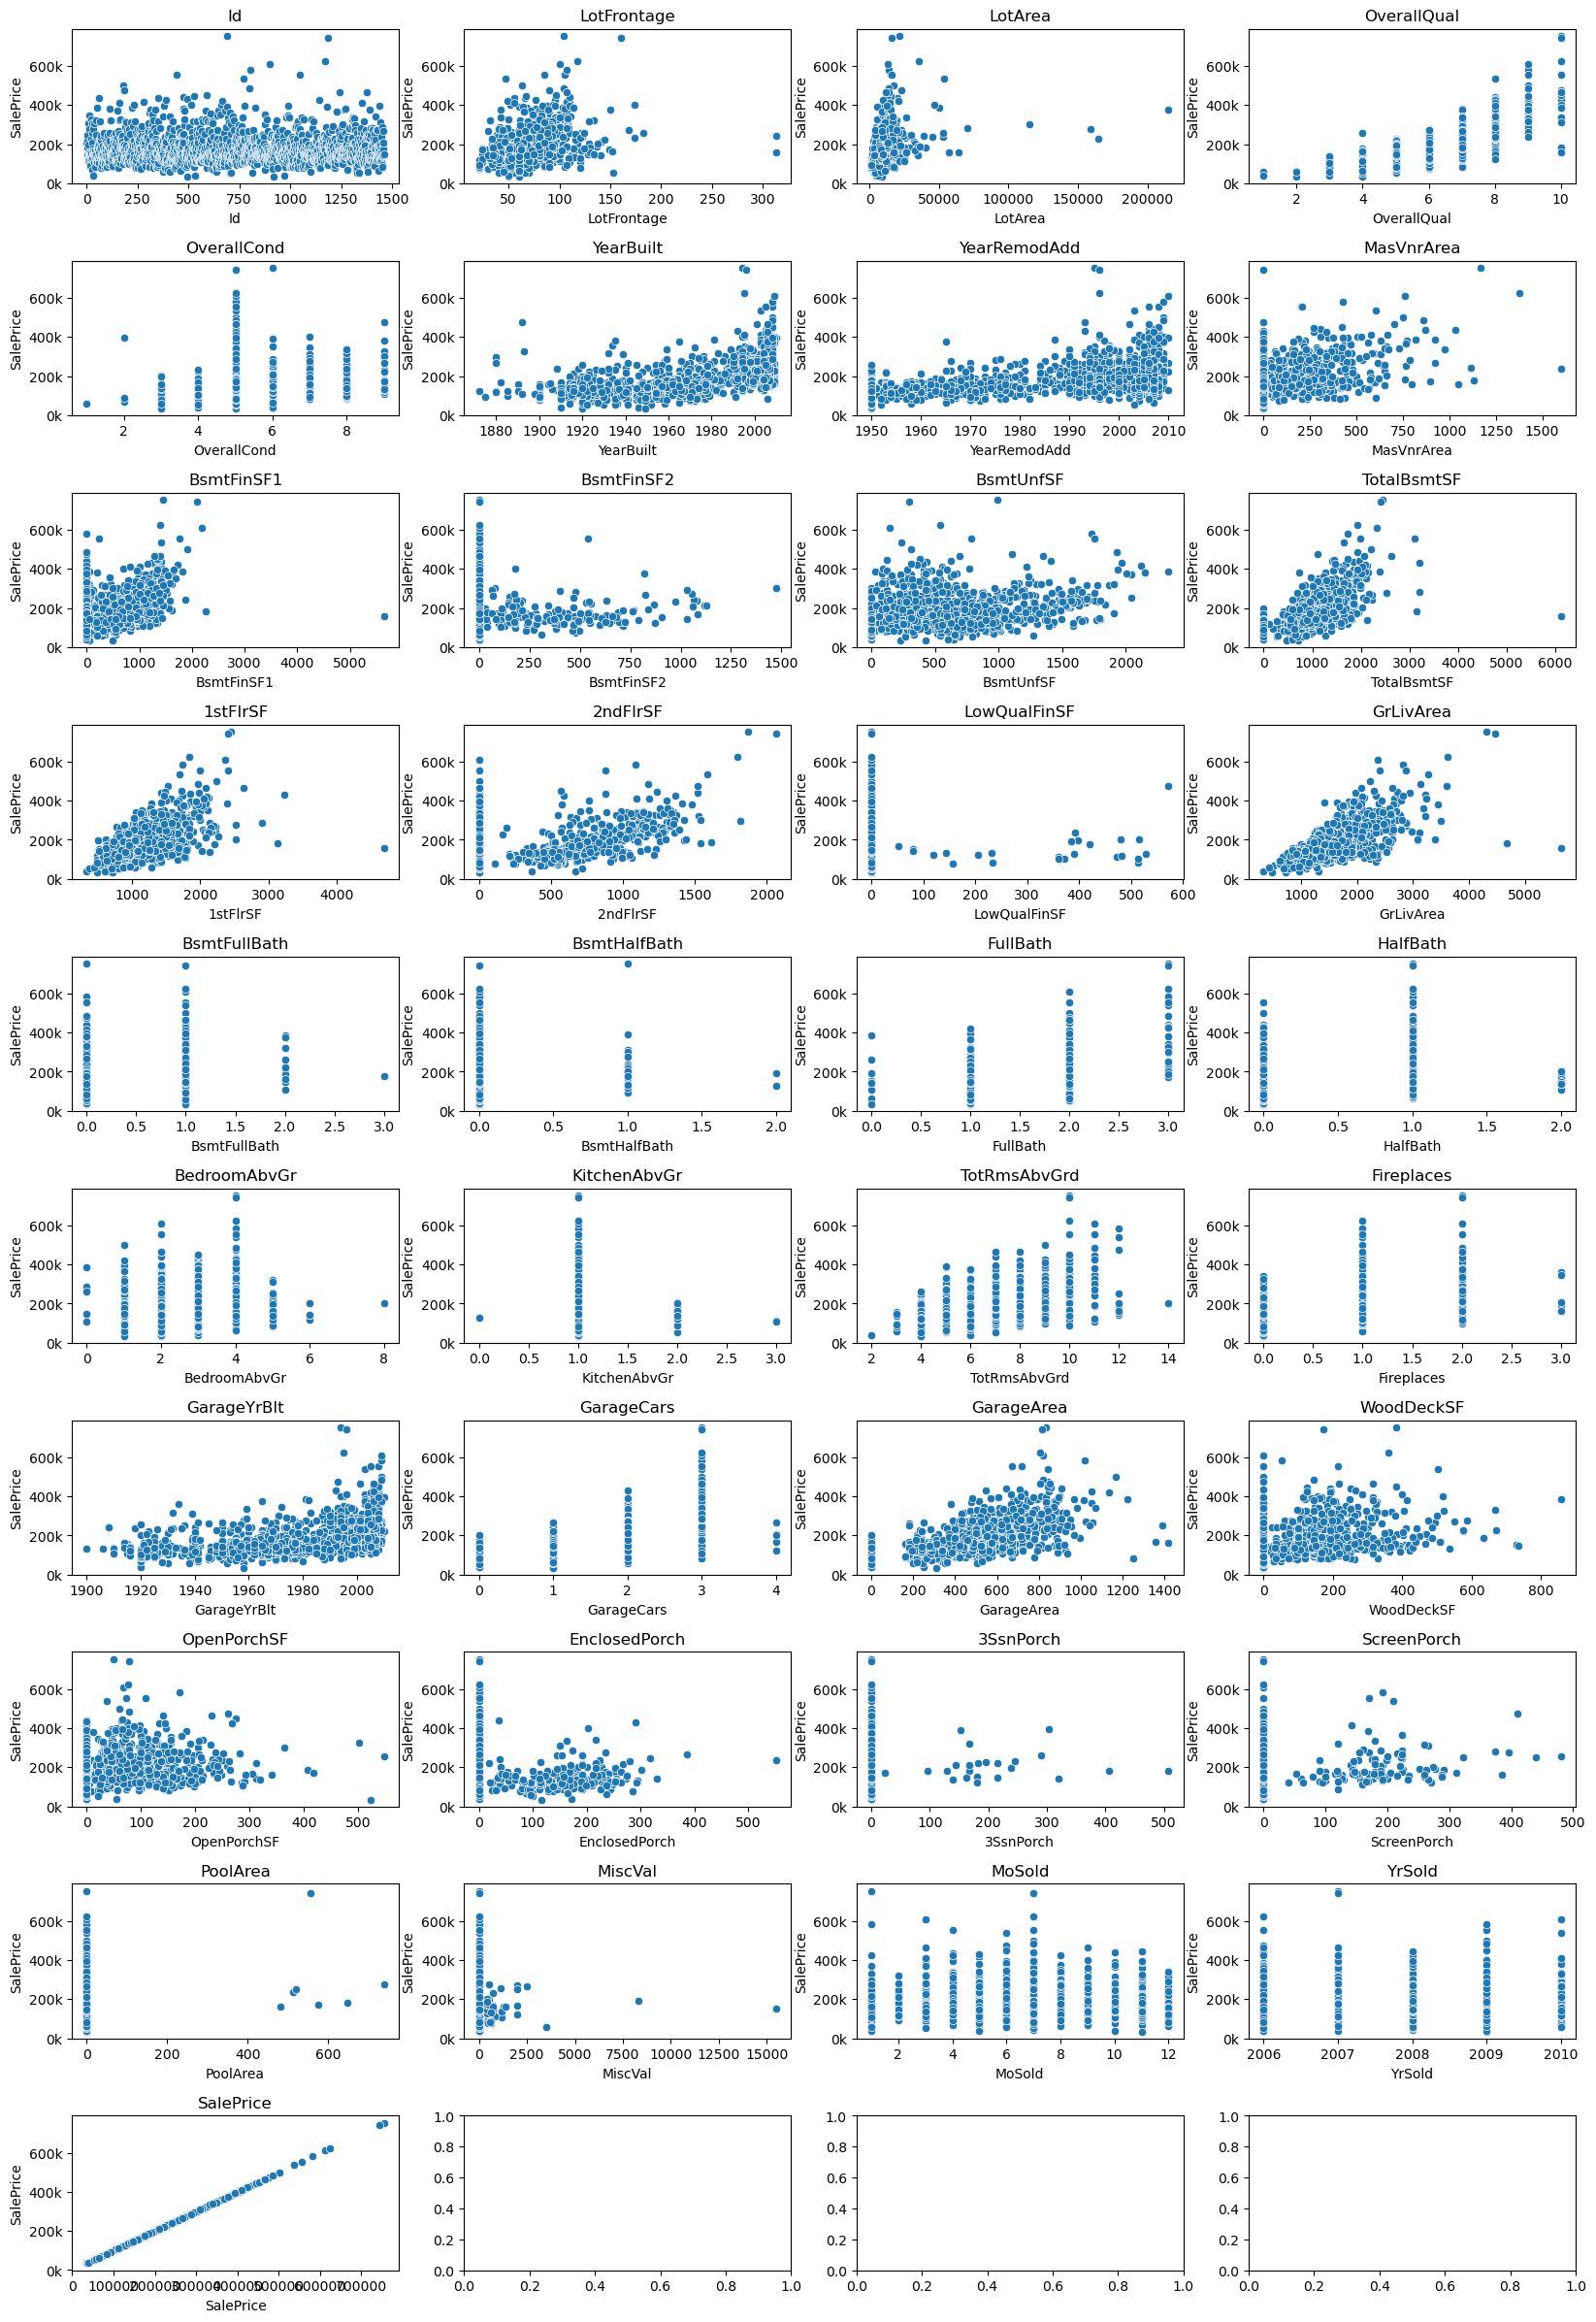

In [14]:
# Plot a scatter plot of each numerical column against the SalePrice column
fig, ax = plt.subplots(10, 4, figsize=(20, 30))
fig.subplots_adjust(hspace=0.5)
for i, col in enumerate(train_data.select_dtypes(include=['int64', 'float64']).columns):
    sns.scatterplot(x=col, y='SalePrice', data=train_data, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(col)
    ax[i//4, i%4].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))
    #ax[i//4, i%4].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))

From the plots above, it can be seen that MSSubclass, and year and month based columns are categorical features despite being encoded as numerical data. However, it is possible to create a numerical feature based on the age of the property when sold (Age = YrSold - YearBuilt).

The same could be done for YearRemodAdd, and GarageYrBlt.

In [15]:
len(train_data.select_dtypes(include=['object', 'category']).columns)

44

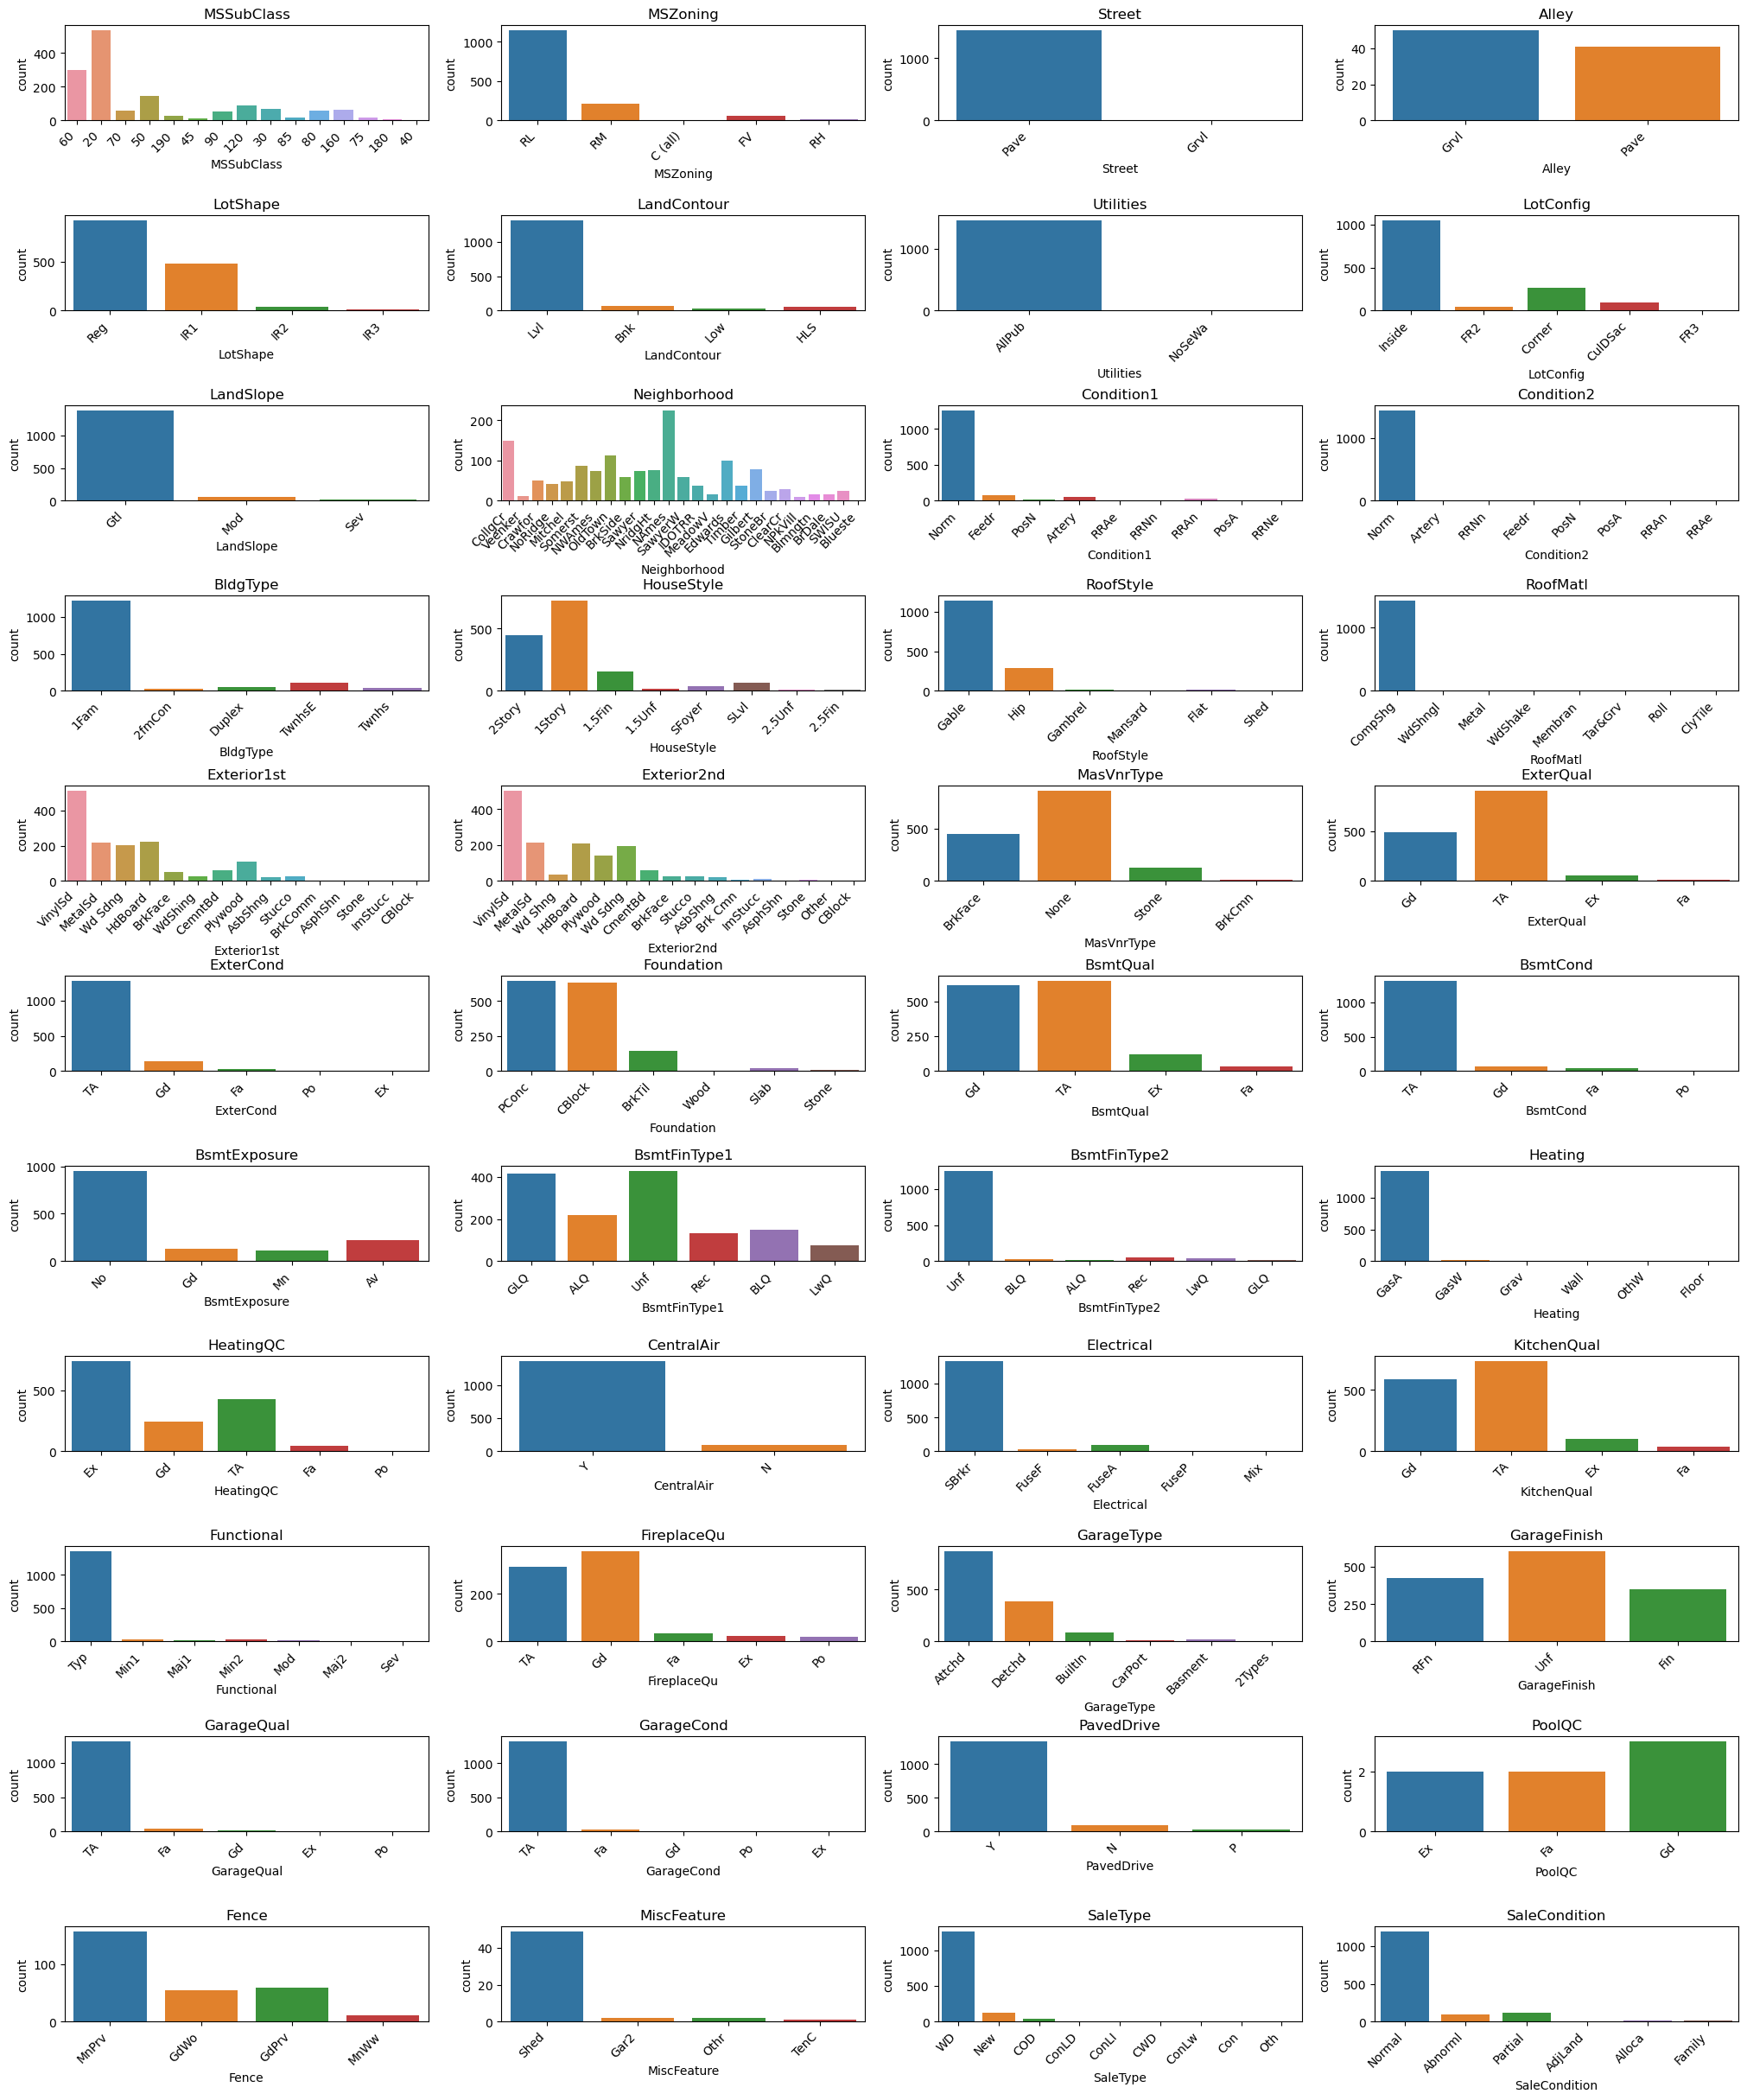

In [16]:
# Plo the distribution of each categorical column with increased vertical space between plots
fig, ax = plt.subplots(11, 4, figsize=(25, 30))
fig.subplots_adjust(hspace=1)
for i, col in enumerate(train_data.select_dtypes(include=['object', 'category']).columns):
    sns.countplot(x=col, data=train_data, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(col)
    ax[i//4, i%4].set_xticklabels(ax[i//4, i%4].get_xticklabels(), rotation=45, horizontalalignment='right')

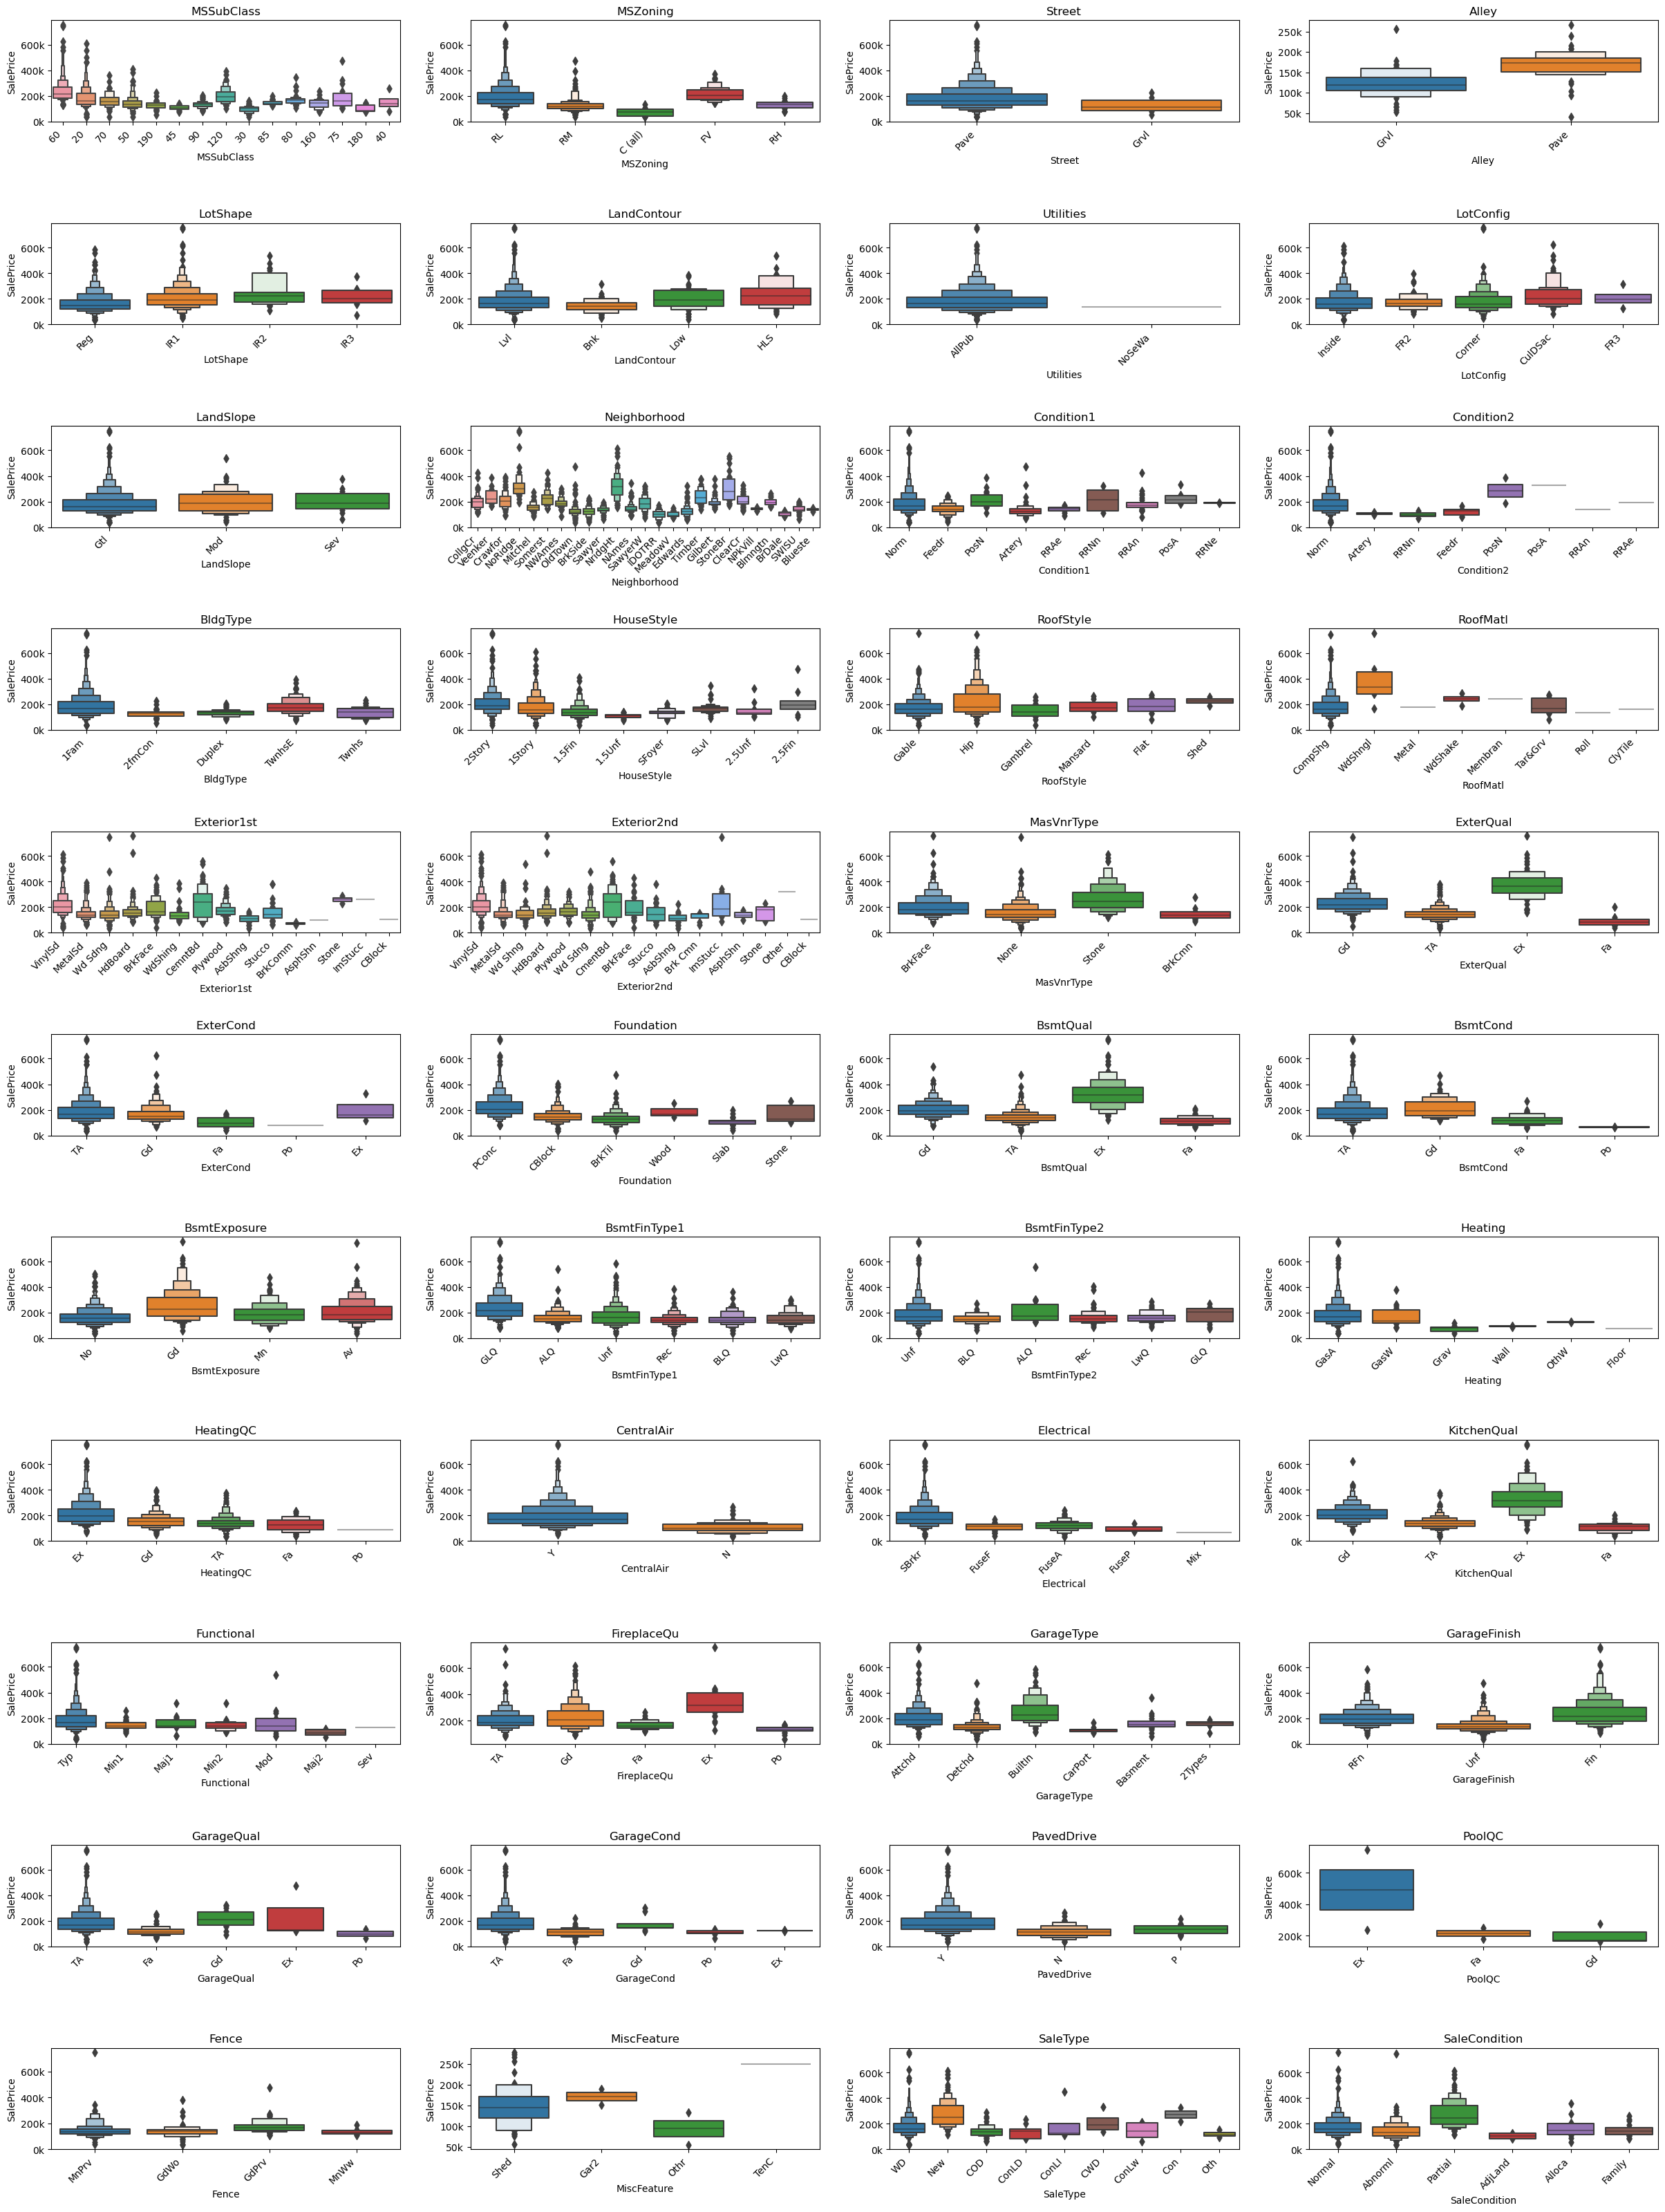

In [17]:
# Plot the mean price for each value of the categorical columns
fig, ax = plt.subplots(11, 4, figsize=(30, 40))#(20, 30)
fig.subplots_adjust(hspace=1)
for i, col in enumerate(train_data.select_dtypes(include=['object', 'category']).columns):
    #sns.barplot(x=col, y='SalePrice', data=train_data, ax=ax[i//4, i%4])
    sns.boxenplot(x=col, y='SalePrice', data=train_data, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(col)
    ax[i//4, i%4].set_xticklabels(ax[i//4, i%4].get_xticklabels(), rotation=45, horizontalalignment='right')
    # Show 100 instead of 100,000 for the price
    ax[i//4, i%4].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000)) + 'k'))


### Mutual Information

In [18]:
# Import mutual info regression from sklearn
from sklearn.feature_selection import mutual_info_regression

# Encode MSSubClass, YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold as categorical
def encode_categorical(df, cols):
    for col in cols:
        df[col] = df[col].astype('category')
    return df

encode_cat_cols = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
encode_cat_cols = ['MSSubClass']
#train_data = encode_categorical(train_data, encode_cat_cols)
train_data['MSSubClass'].dtype

dtype('O')

In [19]:
HTML(train_data.dtypes.to_frame().T.to_html())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,int64,object,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64


In [20]:
# Drop feature columns with missing values
null_cols = train_data.columns[train_data.isnull().any()]
mi_data = train_data.drop(null_cols, axis=1, inplace=False)

# Select numerical cols
#mi_data = mi_data.select_dtypes(include=['int64', 'float64'])


# Create a function to compute the mutual information score
def make_mi_scores(X, y):
    
    # Encode categorical features with factorize.
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = pd.factorize(X[col])[0]
        
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42) #discrete_features=discrete_features or 'auto' or False or True?
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Create a function to plot the mutual information scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(['C0'] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index) if col.startswith('PROBE')]
    color[idx] = 'C3'
    # Create plot
    plt.figure(figsize=(8, 20))
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')
    
# Compute the MI scores for the training data
X = train_data.copy()
y = X.pop('SalePrice')
X = mi_data.copy()
y = X.pop('SalePrice')
mi_scores = make_mi_scores(X, y)
HTML(mi_scores.to_frame().T.to_html())

,OverallQual,GrLivArea,GarageCars,KitchenQual,ExterQual,GarageArea,YearBuilt,TotalBsmtSF,1stFlrSF,FullBath,Foundation,YearRemodAdd,TotRmsAbvGrd,Fireplaces,HeatingQC,MSZoning,Neighborhood,OverallCond,BsmtFinSF1,2ndFlrSF,LotArea,LotShape,HalfBath,SaleCondition,Exterior2nd,MSSubClass,SaleType,BsmtUnfSF,BedroomAbvGr,CentralAir,HouseStyle,OpenPorchSF,BldgType,WoodDeckSF,PavedDrive,Condition1,LandContour,KitchenAbvGr,EnclosedPorch,ExterCond,BsmtFullBath,YrSold,Exterior1st,ScreenPorch,BsmtHalfBath,Functional,LotConfig,RoofStyle,Heating,PoolArea,BsmtFinSF2,RoofMatl,Street,Condition2,MiscVal,LowQualFinSF,3SsnPorch,LandSlope,MoSold,Utilities,Id
MI Scores,0.503562,0.378904,0.365999,0.325385,0.322787,0.291025,0.271776,0.262935,0.248167,0.244992,0.20532,0.203522,0.180563,0.172941,0.16692,0.1279,0.122587,0.121223,0.113433,0.107184,0.097296,0.084593,0.083455,0.077408,0.076117,0.074492,0.069947,0.069654,0.066371,0.066089,0.059374,0.052582,0.049823,0.047518,0.046104,0.033916,0.029856,0.028988,0.025752,0.024034,0.02376,0.022012,0.019323,0.018986,0.015227,0.011215,0.011023,0.010573,0.008641,0.005623,0.004129,0.003831,0.002784,0.000892,0.000075,0.0,0.0,0.0,0.0,0.0,0.0


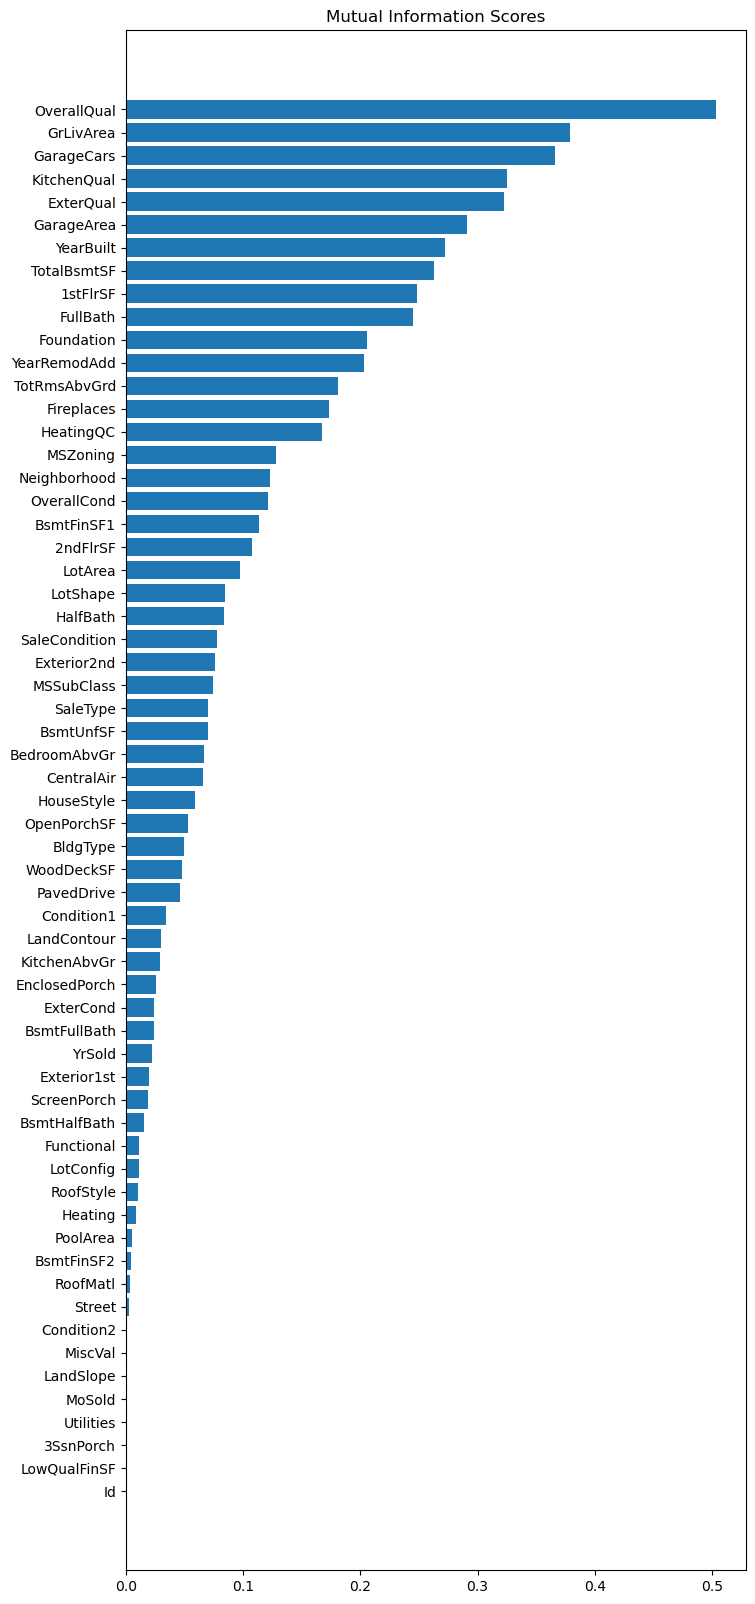

In [21]:
plot_mi_scores(mi_scores)

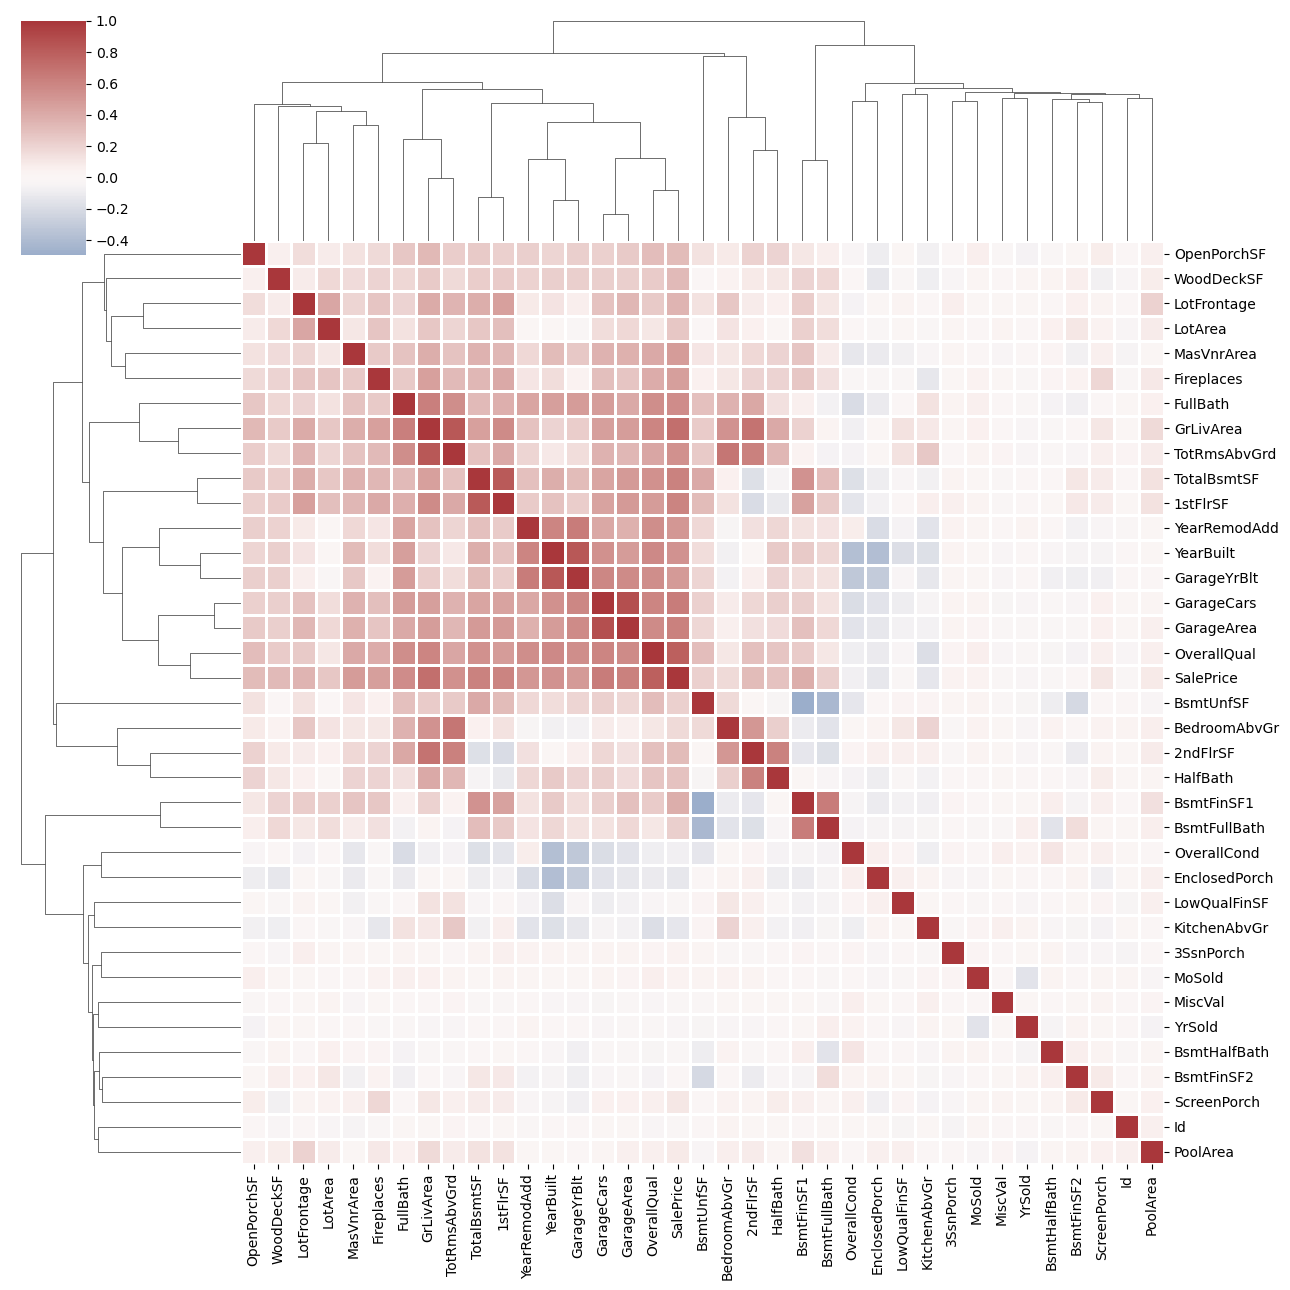

In [22]:
# Sns correlation heatmap
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
sns.clustermap(train_data[num_cols].corr(), center=0, cmap='vlag', linewidths=.75, figsize=(13, 13))

# Data Preprocessing Pipeline

Tree based models can perform better with label and ordinal encoding, whereas, other models generally perform better with one-hot encoding.

In [23]:
# Import sklearn preprocessing pipeline methods
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold

# Import sklearn model selection methods
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor


In [24]:
def make_preprocessor(df=train_data, sparse:bool=False, numerical_imputer='median'): # For tensforflow set sparse=True
    
    df = df.copy()
    if 'SalePrice' in df.columns:
        df = df.drop('SalePrice', axis=1, inplace=False)
    
    # Numerical columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler()) #median

    # Categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # Can attempt the 'most_frequent' and 'constant' strategies for imputation
    categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore', sparse_output=sparse))

    # Combine the pipelines into a column transformer
    preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols), ('cat', categorical_transformer, cat_cols)], remainder='passthrough', verbose=False)
    preprocessor = make_column_transformer((numerical_transformer, num_cols), (categorical_transformer, cat_cols), remainder='passthrough', verbose=False)
    
    return preprocessor

preprocessor = make_preprocessor(sparse=False)
pipeline = make_pipeline(preprocessor)


# Hyperparameter Tuning: Grid Search

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, train_test_split

# When using GridSearchCV with Pipelines, use model_name__parameter_name

# Add the model name to the parameters
def grid_pipe_params(params, model_name):
    return {model_name + '__' + key: value for key, value in params.items()}

# Remove model_name__ from keys
def remove_model_name(params):
    return {key.split('__')[1]: value for key, value in params.items()}

# Find the optimum model hyperparameters
def grid_search(model, params, X, y):
    search = GridSearchCV(
        model, 
        params, 
        cv=5, 
        scoring= ['neg_mean_squared_error', 'mean_squared_error'][0],
        n_jobs=-1).fit(X, y)
    return search

# Combine the grid search related functions defined above
def grid_search_hyperparameters(params, model, X, y, model_name=False):
    model_name = model_name if model_name else model.steps[-1][0]
    params = grid_pipe_params(params, model_name)
    search = grid_search(model, params, X, y)
    return search

# Models

In [26]:
# model includes a preprocessing pipeline
class Model:
    
    def __init__(self, model, pipeline, params=None, df=train_data):
        self.model = model
        self.pipeline = pipeline
        self.model_pipeline = Pipeline(steps=[('preprocessor', self.pipeline), ('model', self.model)])

        self.scoring = 'neg_mean_squared_error'
        self.n_cv = 3
        self.cv = KFold(n_splits=self.n_cv, shuffle=True, random_state=42)
        self.params = params
    
        self.df = df
        self.X = self.df.drop('SalePrice', axis=1, inplace=False)
        self.y = self.df['SalePrice']
        
        # Split the data into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        
    def steps_tuned(self, print_=True):
        search = grid_search_hyperparameters(self.params, self.model_pipeline, self.X_train, self.y_train) # Changed to X_train, y_train
        params = search.best_params_
        params = remove_model_name(params)
        self.cv_score = np.sqrt(-1 * search.best_score_)
        best = search.best_estimator_
        #best.fit(self.X, self.y)
        self.eval_score = self.evaluate(model=best)

        self.params = params
        self.best = best
        self.search = search 
        
        if print_:
            print(f'Model: {self.model.__class__.__name__}')
            print(f'{self.n_cv} fold cross-val score: {self.cv_score:,.0f}')
            print(f'Test set evaluation score: {self.eval_score:,.0f}')
        
        return self.cv_score, self.eval_score, params, best
    
    def steps_untuned(self, print_=True):
        self.cv_score = self.score_cv()
        self.fit()
        self.eval_score = self.evaluate(model=self.model_pipeline)
        if print_:
            print(f'Model: {self.model.__class__.__name__}')
            print(f'{self.n_cv} fold cross-val score: {self.cv_score:,.0f}')
            print(f'Test set evaluation score: {self.eval_score:,.0f}')
        return self.cv_score, self.eval_score
        
    def fit(self):
        self.model_pipeline.fit(self.X_train, self.y_train) # Changed to X_train, y_train
        return self
    
    def score_cv(self):
        scores = -1 * cross_val_score(self.model_pipeline, self.X_train, self.y_train, cv=self.cv, scoring=self.scoring) # Changed to X_train, y_train
        score = scores.mean()
        score = np.sqrt(score)
        return score
    
    def score(self):
        return self.model_pipeline.score(self.X_test, self.y_test)
    
    def predict(self, X_pred):
        return self.model_pipeline.predict(X_pred)
    
    def evaluate(self, model, scoring='rmse'):
        """Evaluate the model on the test set using RMSE."""
        y_pred = model.predict(self.X_test)
        if scoring=='rmse':
            return np.sqrt(mean_squared_error(self.y_test, y_pred))
            #return model.score(self.X_test, self.y_test)
        elif scoring=='neg_mean_squared_error':
            return mean_squared_error(self.y_test, y_pred)

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor

## Classical Models

In [28]:
lr = LinearRegression()
lr = Model(lr, pipeline).steps_untuned()
print()
lr = LinearRegression()
lr_params = {}
lr = Model(lr, pipeline, params=lr_params).steps_tuned()

Model: LinearRegression
3 fold cross-val score: 529,376,542,685,963
Test set evaluation score: 234,962,145,634,906



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: LinearRegression
3 fold cross-val score: 198,134,229,758,903
Test set evaluation score: 234,962,145,634,906


In [29]:
X_preprocessed = pipeline.fit_transform(train_data.drop('SalePrice', axis=1, inplace=False))
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr_params = {}
search = GridSearchCV(estimator=lr, param_grid=lr_params, cv=KFold(3, shuffle=True, random_state=42), scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
search.fit(X_train, y_train)
print(search.best_params_)
print(f"{np.sqrt(-1* search.best_score_):,.0f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{}
286,966,441,166,308


In [30]:
svr = SVR()
svr = Model(svr, pipeline).steps_untuned()
print()
lsvr = LinearSVR()
lsvr = Model(lsvr, pipeline).steps_untuned()

Model: SVR
3 fold cross-val score: 78,953
Test set evaluation score: 88,627

Model: LinearSVR
3 fold cross-val score: 176,576
Test set evaluation score: 169,142


In [31]:
rf = RandomForestRegressor(random_state=42)
rf = Model(rf, pipeline).steps_untuned()
print()
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
}
rf = RandomForestRegressor(random_state=42)
rf = Model(rf, pipeline, params=rf_params).steps_tuned()

Model: RandomForestRegressor
3 fold cross-val score: 32,174
Test set evaluation score: 28,749

Model: RandomForestRegressor
3 fold cross-val score: 31,033
Test set evaluation score: 29,281


In [32]:
xgb = XGBRegressor(random_state=42)
xgb = Model(xgb, pipeline).steps_untuned()
print()
xgb_params = {}
xgb = XGBRegressor(random_state=42)
xgb = Model(xgb, pipeline, params=xgb_params).steps_tuned()
print()
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
}
xgb_tuned = XGBRegressor(random_state=42)
xgb_tuned = Model(xgb_tuned, pipeline, params=xgb_param_grid).steps_tuned()

Model: XGBRegressor
3 fold cross-val score: 32,529
Test set evaluation score: 29,677

Model: XGBRegressor
3 fold cross-val score: 31,901
Test set evaluation score: 29,677

Model: XGBRegressor
3 fold cross-val score: 29,597
Test set evaluation score: 29,359


## Feature Engineering

### Custom Features

In [33]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [34]:
def create_features(df):
    df = df.copy()
    cat_dtype = ('object', 'category')[0] # 'category' doesn't seem to work with the categorical imputer

    df['HomeAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    
    df['Remodel'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(cat_dtype)
    df['Garage'] = (df['GarageArea'] > 0).astype(cat_dtype)
    df['Bsmt'] = (df['TotalBsmtSF'] > 0).astype(cat_dtype)
    df['2ndFloor'] = (df['2ndFlrSF'] > 0).astype(cat_dtype)
    df['Porch'] = (df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] > 0).astype(cat_dtype)
    
    df['CombinedBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    return df

# Encode categorical features
def encode_categorical(df):
    cols = ['MoSold', 'YrSold'] #'MSSubClass' already encoded
    for col in cols:
        df[col] = df[col].astype(('object', 'category')[0]) # 'category' doesn't seem to work with the categorical imputer
    return df

def encode_numerical(df):
    # Encode as numerical features
    cols = []
    for col in cols:
        df[col] = df[col].astype('int64')
    return df

def encode_cols(df):
    df = encode_categorical(df)
    df = encode_numerical(df)
    return df

In [35]:
train_data_new = create_features(train_data)
train_data_new = encode_cols(train_data_new)
pipeline_fe = make_pipeline(make_preprocessor(df=train_data_new))

xgb = XGBRegressor(random_state=42)
xgb = Model(xgb, pipeline_fe, df=train_data_new).steps_untuned()

Model: XGBRegressor
3 fold cross-val score: 32,582
Test set evaluation score: 30,720


### Principal Component Analysis (PCA)

In [36]:
from sklearn.decomposition import PCA

# Find the number of components needed to explain 95% of the variance
#pca = PCA()
#data = pipeline.fit_transform(train_data.drop('SalePrice', axis=1, inplace=False))
#data_pca = pca.fit_transform(data)
#cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
#print(f'Number of components: {n_components}')

# Define the PCA pipeline with the number of components
#pca = PCA(n_components=n_components)
#pipeline_pca = make_pipeline(make_preprocessor(sparse=False), pca)
##data_pca = pipeline_pca.fit_transform(train_data.drop('SalePrice', axis=1, inplace=False))

def apply_pca(df=train_data):
    df = df.copy()
    
    pipeline = make_pipeline(make_preprocessor(sparse=False, df=df))
    # Find the number of components needed to explain 95% of the variance
    pca = PCA()
    data = pipeline.fit_transform(df.drop('SalePrice', axis=1, inplace=False))
    data_pca = pca.fit_transform(data)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components: {n_components}')

    # Define the PCA pipeline with the number of components
    pca = PCA(n_components=n_components)
    pipeline_pca = make_pipeline(make_preprocessor(sparse=False, df=df), 
                                pca)
    
    return pipeline_pca, pca

pipeline_pca, pca = apply_pca(train_data)

Number of components: 83


In [37]:
# Test the models with PCA
xgb_pca = XGBRegressor(random_state=42)
xgb_pca = Model(xgb_pca, pipeline_pca).steps_untuned()
print()
lr_pca = LinearRegression()
lr_pca = Model(lr_pca, pipeline_pca).steps_untuned()

Model: XGBRegressor
3 fold cross-val score: 31,154
Test set evaluation score: 29,394

Model: LinearRegression
3 fold cross-val score: 37,454
Test set evaluation score: 33,262


### Custom Features + Principal Component Analysis (PCA):

In [38]:
# Find the number of components needed to explain 95% of the variance
#pca = PCA()
#data = pipeline_fe.fit_transform(train_data_new.drop('SalePrice', axis=1, inplace=False)) # , train_data['SalePrice']
#data_pca = pca.fit_transform(data)
#cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
#n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Define the pca pipeline with the number of components
#pca = PCA(n_components=n_components)
#pipeline_fe_pca = make_pipeline(make_preprocessor(sparse=False, df=train_data_new), pca)

pipeline_fe_pca, pca = apply_pca(train_data_new)

# Test the models with the Custom Features + PCA pipeline
xgb = XGBRegressor(random_state=42)
xgb = Model(xgb, pipeline_fe_pca, df=train_data_new).steps_untuned()
print()
lr = LinearRegression()
lr = Model(lr, pipeline_fe_pca, df=train_data_new).steps_untuned()

Number of components: 91
Model: XGBRegressor
3 fold cross-val score: 32,176
Test set evaluation score: 28,393

Model: LinearRegression
3 fold cross-val score: 38,011
Test set evaluation score: 32,997


### KMeans Clustering

In [39]:
from sklearn.cluster import KMeans

#cluster_cols = ['MSSubClass', 'MSZoning', 'Neighborhood']
#cluster_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'EnclosedPorch', 'PoolArea', 'MiscVal']

# Find the optimal number of clusters
def n_clusters(k_range, model=XGBRegressor(random_state=42)):
    """Find the optimal number of clusters."""
    cv_scores = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        pipeline_kmeans = make_pipeline(make_preprocessor(sparse=False), 
                                        kmeans)
        cv_score = Model(model, pipeline_kmeans).steps_untuned(print_=False)[0]# Change when the method's return values are modified
        cv_scores[k] = cv_score
    best_k = min(cv_scores, key=cv_scores.get)
    return best_k
        
best_n = n_clusters(range(2, 10))
print(f'Best number of clusters: {best_n}')

kmeans = KMeans(n_clusters=best_n, random_state=42)
pipeline_kmeans = make_pipeline(make_preprocessor(sparse=False), 
                                kmeans)
train_data_kmeans = pipeline_kmeans.fit_transform(train_data.drop('SalePrice', axis=1, inplace=False))
train_data_kmeans

Best number of clusters: 7


array([[11.54888508,  6.71321692,  7.57698101, ...,  8.53282774,
         5.8656987 ,  4.19132787],
       [12.15348983,  6.64349804,  7.9713578 , ...,  9.3783659 ,
         7.69233275,  7.96052962],
       [11.64124291,  6.59047275,  7.5600398 , ...,  8.66220498,
         5.36769588,  3.91511757],
       ...,
       [12.69990956,  9.9064103 ,  9.61953078, ..., 10.49695483,
        10.38823826,  9.42604163],
       [13.30709717,  8.26762554,  8.94631661, ..., 10.95895654,
        10.25316805, 10.43383367],
       [12.45692733,  7.01572331,  8.13850293, ...,  9.82232629,
         8.70007712,  8.62646567]])

In [40]:
xgb_kmeans = XGBRegressor(random_state=42)
xgb_kmeans = Model(xgb_kmeans, pipeline_kmeans).steps_untuned()
print()
lr_kmeans = LinearRegression()
lr_kmeans = Model(lr_kmeans, pipeline_kmeans).steps_untuned()

Model: XGBRegressor
3 fold cross-val score: 35,337
Test set evaluation score: 39,843

Model: LinearRegression
3 fold cross-val score: 36,447
Test set evaluation score: 37,868


### Smoothed Target Encoding
MEstimateEncoder() performs the target encoding inplace without creating new columns.

In [41]:
from category_encoders import MEstimateEncoder

cat_cols = ['MSSubClass', 'MSZoning', 'Neighborhood']
#cat_cols = train_data.select_dtypes(include=['object', 'category']).columns.tolist()

def smoothing_parameter(m_range, df=train_data, model=XGBRegressor(random_state=42), cat_cols=cat_cols):
    """Find the optimal smoothing parameter."""
    df = df.copy()
    cv_scores = {}
    for m in m_range:
        encoder = MEstimateEncoder(cols=cat_cols, m=m)
        data = encoder.fit_transform(df, train_data['SalePrice'])
        pipeline_e = make_pipeline(make_preprocessor(sparse=False, df=data))
        cv_score = Model(model, pipeline_e, df=data).steps_untuned(print_=False)[0]
        cv_scores[m] = cv_score
    best_m = min(cv_scores, key=cv_scores.get)
    return best_m

In [42]:
# Select data to use
#data_e = train_data.copy()

# Find the optimal smoothing parameter
#best_m = smoothing_parameter(np.arange(1, 10, 0.5), df=data_e)
#print(f'Best smoothing parameter: {best_m}')

# Create the encoder, encoded data, and pipeline
#encoder = MEstimateEncoder(cols=cat_cols, m=best_m)
#data_e = encoder.fit_transform(data_e, data_e['SalePrice'])
#pipeline_e = make_pipeline(make_preprocessor(sparse=False, df=data_e))

def apply_target_encoding(m_range=np.arange(1, 10, 0.5), df=train_data, cat_cols=cat_cols):
    # Select data to use
    df = df.copy()

    # Find the optimal smoothing parameter
    best_m = smoothing_parameter(np.arange(1, 10, 0.5), df=df, cat_cols=cat_cols)
    print(f'Best smoothing parameter: {best_m}')

    # Create the encoder, encoded data, and pipeline
    encoder = MEstimateEncoder(cols=cat_cols, m=best_m)
    data_e = encoder.fit_transform(df, df['SalePrice'])
    pipeline = make_pipeline(make_preprocessor(sparse=False, df=data_e))
    
    return encoder, pipeline, data_e

encoder, pipeline_e, data_e = apply_target_encoding(np.arange(1, 10, 0.5), df=train_data, cat_cols=cat_cols)

Best smoothing parameter: 7.0


In [43]:
# Test the models with the Custom Features + PCA pipeline
xgb = XGBRegressor(random_state=42)
xgb = Model(xgb, pipeline_e, df=data_e).steps_untuned()
print()
lr = LinearRegression()
lr = Model(lr, pipeline_e, df=data_e).steps_untuned()

Model: XGBRegressor
3 fold cross-val score: 31,654
Test set evaluation score: 28,498

Model: LinearRegression
3 fold cross-val score: 273,702,304,882,345
Test set evaluation score: 187,349,383,328,750


# Sklearn Neural Network

In [44]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42, max_iter=1000, n_iter_no_change=10, learning_rate_init=0.001)
mlp = Model(mlp, pipeline).steps_untuned()

Model: MLPRegressor
3 fold cross-val score: 129,373
Test set evaluation score: 72,511


In [45]:
mlp_param_grid = {
    'hidden_layer_sizes': [(10,), (10, 10)],# (10, 10, 10), {20, 10, 5}],
    'activation': ['relu', 'tanh'],#, 'logistic'],
    'solver': ['adam'],#, 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}
mlp_tuned = MLPRegressor(random_state=42, max_iter=1000, n_iter_no_change=10, learning_rate_init=0.001, early_stopping=True)
mlp_tuned = Model(MLPRegressor(mlp_tuned), pipeline, params=mlp_param_grid).steps_tuned()

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Model: MLPRegressor
3 fold cross-val score: 183,248
Test set evaluation score: 187,897


In [46]:
mlp_tuned = MLPRegressor(random_state=42, max_iter=1000, n_iter_no_change=10, learning_rate_init=0.001)

X = train_data.drop('SalePrice', axis=1, inplace=False)
X_preprocessed = pipeline.fit_transform(X)
y = train_data['SalePrice'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

mlp_tuned = GridSearchCV(mlp_tuned, param_grid=mlp_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
mlp_tuned.fit(X_train, y_train)
print(mlp_tuned.best_params_)
print(f"5 fold cross validation score: {np.sqrt(-1 * mlp_tuned.best_score_):,.0f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
5 fold cross validation score: 38,791


## Tensorflow Deep Learning
Use One-Hot encoding and scale the data.
For feature scaling use normalization, unless the feature:
* Has a Gaussian/Normal distribution.
* Has outliers that would skew the distribution if normalized. 

In [47]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Input, Embedding, SpatialDropout1D, LayerNormalization

In [48]:
X = train_data.drop('SalePrice', axis=1, inplace=False).copy()
y = train_data['SalePrice'].copy()

#pipeline.fit(X)
X_transformed = pipeline.fit_transform(X)
#dataset = tf.data.Dataset.from_tensor_slices(X_transformed)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))  # assuming y is your target variable
#dataset_train = dataset_train.batch(32)  # assuming you want to use a batch size of 32
#dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))  # assuming y is your target variable

In [49]:
type(X_transformed)

numpy.ndarray

In [50]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(128*8, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128*4, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128*2, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

# Define the rmse metric and loss
def rmse(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 319)]             0         
                                                                 
 dense (Dense)               (None, 1024)              327680    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [51]:
#X_train = X_train.to_numpy()
#vectorizer.adapt(X_train)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model', monitor='val_loss', mode='min', save_best_only=True)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32*4, epochs=25*10, callbacks=callbacks, verbose=False)

loaded_model = tf.keras.models.load_model('best_model')

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


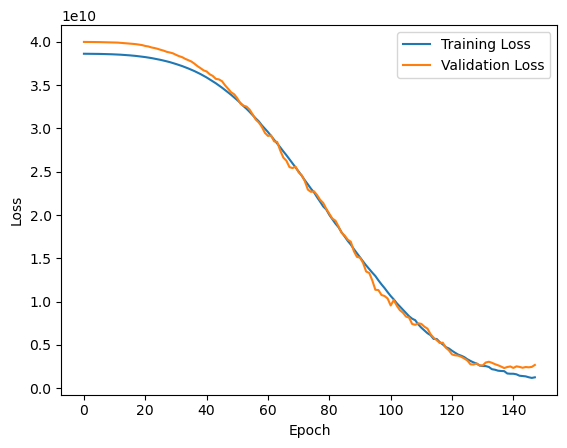

In [52]:
def plot_loss(history):
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(history=history)

In [53]:
tf_score = loaded_model.evaluate(X_test, y_test)[1]
tf_score = np.sqrt(tf_score)

10/10 [==============================] - 0s 4ms/step - loss: 2102326144.0000 - mse: 2102326144.0000


In [54]:
print(f"Test set evaluation score: {tf_score:,.0f}")

Test set evaluation score: 45,851


# Best Model

Further feature engineering and selection work is needed with more tuned models to obtain better results. <br>
But to demonstrate that the model works, I am going to select the untuned XGBRegressor with Custom Features, Target Encoding, and PCA.

In [55]:
# Prepare training data for the entire train_data set

# Create custom features
dataset = train_data.copy()
dataset = create_features(dataset)
dataset = encode_cols(dataset)

# Perform Target Encoding
encoder, pipeline_e, dataset_e = apply_target_encoding(df=dataset)

# Create PCA pipeline
pipeline_pca, pca = apply_pca(df=dataset)

pipeline = make_pipeline(make_preprocessor(sparse=False, df=dataset), pca)
X = dataset.drop('SalePrice', axis=1, inplace=False)
y = dataset['SalePrice'].copy()
X = pipeline_pca.fit_transform(X)

Best smoothing parameter: 4.0
Number of components: 91


In [56]:
type(dataset)

pandas.core.frame.DataFrame

In [57]:
# Prepare submission data
X_submission = test_data.copy()
X_submission = create_features(X_submission)
X_submission = encode_cols(X_submission)
#X_submission = encoder.transform(X_submission)

X_submission = pipeline_pca.transform(X_submission)

In [58]:
model = XGBRegressor(random_state=42)
#model = make_pipeline(pipeline, xgb)
model.fit(X, y)
predictions = model.predict(X_submission)

# Predictions & Submission

In [59]:
pred_data = pd.read_csv(data_path / 'test.csv')
#predictions = model.predict(X_pred)
submission = pred_data[['Id']].copy()
submission['SalePrice'] = predictions
submission.to_csv("submission.csv", index=False)
submission

,Id,SalePrice
0,1461,121615.648438
1,1462,144916.500000
2,1463,174352.984375
3,1464,188450.062500
4,1465,186459.796875
...,...,...
1454,2915,100549.546875
1455,2916,87448.960938
1456,2917,160309.281250
1457,2918,116132.015625
